# 7T MRI Dataloader 
Update: 18.6.2023

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pandas
import pydicom as dcm
from pydicom.data import get_testdata_files
import pickle
import nibabel as nib
from sklearn.model_selection import train_test_split
import random
import math
import json

## 1. Loading the file and sorting keys and attributes

In [11]:
labelpath = '7TMRIs/Neal_7T_Cartilages.hdf5'
exportedSegMasks = [] # masks (multi-class)
filenames = [] # filenames
normalizedImages = [] # the 7T MRI (80 slices in total)
offsets = [] # all 0,0 - can be ignored 
sides = [] # don't know what's that - can be ignored 
slices = [] # indicate slice number

with h5py.File(labelpath) as hf:
    
### Uncomment to print the name and attributes of each item
#     def print_attrs(name, obj):
#         print(name)
#         if isinstance(obj, h5py.Group):
#             for key, val in obj.attrs.items():
#                 print("    %s: %s" % (key, val))
#     hf.visititems(print_attrs) # visititems to apply the print_attrs function to each item in the file
    
    
## Uncomment to print the list of keys 
    keyList = list(hf.keys())
#     print(keyList)
    
    
###  Extract specific datasets associated to different keys (see key list)

    ContourId = hf['ContourId'][:] # 1. Contour ID (not useful)
    Label = hf['Label'][:] # 2. Label (number, telling 9-class segmentation label)
    LabelNames = hf['LabelNames'][:] # 3. Names of each class in the 9-class label
    
    for key in keyList[3:-1]:
        Slice = hf[key] # each key => contains 5 groups 
        exportedSegMasks.append(Slice['exportedSegMask'][:]) # masks (multi-class)
        filenames.append(Slice['filename'][:]) # filenames
        normalizedImages.append(Slice['normalizedImage'][:]) # the 7T MRI (80 slices in total)
        offsets.append(Slice['offset'][:]) # all 0,0 - can be ignored 
        sides.append(Slice['side'][:]) # don't know what's that - can be ignored 
        slices.append(Slice['slice'][:]) # indicate slice number
        
    StructureId = hf['StructureId'][:]
    
    print('Contour ID: ', ContourId)
    print('Label Classes: ', Label)
    print('Label Names: ', LabelNames)
    print('Total number of MRI slices: ', len(filenames))


### E.g. look into all attributes under slice 0001   
    print('\nSlice Example: ')
    slice0 = hf['Slice0001']

    # Check what attributes are in slice0001
    for obj_name in slice0:
        obj = slice0[obj_name]
        print(obj)
        
    
    exportedSegMask = slice0['exportedSegMask'][:]
    filename = slice0['filename'][:]
    normalizedImage = slice0['normalizedImage'][:]
    offset = slice0['offset'][:]
    side = slice0['side'][:]
    slice_ = slice0['slice'][:]

    print('\nSize of the segmentation mask of the slice:')
    print(slice0['exportedSegMask'][:].shape)
    
    print('\nFilename:')
    print(slice0['filename'][:])
    
    print('\nSize of the image slice:')
    print(slice0['normalizedImage'][:].shape)
    
    print('\nOffset:')
    print(slice0['offset'][:])
    
    print('\nSide:')
    print(slice0['side'][:])
    
    print('\nSlice number:')
    print(slice0['slice'][:])
    

Contour ID:  [-1 -1 -1 -1 -1 -1 -1 -1 -1]
Label Classes:  [1 2 3 4 5 6 7 8 9]
Label Names:  [b'Patella' b'Medial Tibia' b'Central medial femoral condyle'
 b'Lateral Tibia' b'Central lateral femoral condyle'
 b'Trochlea of the femur' b'Posterior medial femoral condyle'
 b'Posterior lateral femoral condyle' b'Patella Bone']
Total number of MRI slices:  1120

Slice Example: 
<HDF5 dataset "exportedSegMask": shape (512, 512), type "|u1">
<HDF5 dataset "filename": shape (1,), type "|S1024">
<HDF5 dataset "normalizedImage": shape (512, 512), type "<f4">
<HDF5 dataset "offset": shape (2,), type "<i4">
<HDF5 dataset "side": shape (1,), type "|S64">
<HDF5 dataset "slice": shape (1,), type "<i4">

Size of the segmentation mask of the slice:
(512, 512)

Filename:
[b'No01_7T-footballer_F7T-2015-41-006_Sag_female-footballer-1_152634.512500_qcfin_qcfin.six']

Size of the image slice:
(512, 512)

Offset:
[0 0]

Side:
[b'']

Slice number:
[1]


## 2. Sorting unique files and counting MRI slices in each file

In [3]:
filenames_str = [elem.astype(str).tolist() for elem in filenames]
filenames_str = [elem[0] for elem in filenames_str]

uniqueFiles = sorted(list(set(filenames_str)))

for elem in uniqueFiles:
    count = filenames_str.count(elem)
    print(f"{elem}: {count}")

# No01 - Female footballer 1 - Right knee
# No01 - Female footballer 1 - Left knee

# No02 - Female footballer 2 - Right knee
# No02 - Female footballer 2 - Left knee

# No03 - Footballer 1 - Right knee

# No04 - Footballer 2 - Right knee

# No05 - Footballer 3 - Right knee
# No05 - Footballer 3 - Left knee

# No06 - Footballer 4 - Right knee
# No06 - Footballer 4 - Left knee

# No07 - Subject 1 - Left knee
# No07 - Subject 1 - Right knee

# No08 - Subject 2 - Left knee
# No08 - Subject 2 - Right knee

No01_7T-footballer_F7T-2015-41-006_Sag_female-footballer-1_152634.512500_qcfin_qcfin.six: 80
No01_7T-footballer_F7T-2015-41-008_Sag_female-footballer-1_163140.910000_qcfin_qcfin.six: 80
No02_7T-footballer_F7T-2015-41-009_Sag_trufi-rsos-female-footballer-2_184902.505000_qcfin_qcfin.six: 80
No02_7T-footballer_F7T-2015-41-009_Sag_trufi-rsos-female-footballer-2_193846.297500_qcfin_qcfin.six: 80
No03_7T-footballer_F7T-2014-05-071_Sag_trufi-rsos-footballer-1_155530.420000_qcfin_qcfin.six: 80
No04_7T-footballer_F7T-2014-05-072_Sag_trufi-rsos-footballer-2_164723.477500_qcfin_qcfin.six: 80
No05_7T-footballer_F7T-2015-41-001_Sag_footballer-3_155639.525000_qcfin_qcfin.six: 80
No05_7T-footballer_F7T-2015-41-004_Sag_footballer-3_173358.525000_qcfin_qcfin.six: 80
No06_7T-footballer_F7T-2015-41-002_Sag_footballer-4_164615.505000_qcfin_qcfin.six: 80
No06_7T-footballer_F7T-2015-41-005_Sag_PC-bSSFP-rsos3_180121.985000_qcfin_qcfin.six: 80
No07_7T-footballer_F7T-2014-05-065_Sag_Trufi-rsos4_084327.472500_q

### Example: visualising No01-footballer's image slices (80)

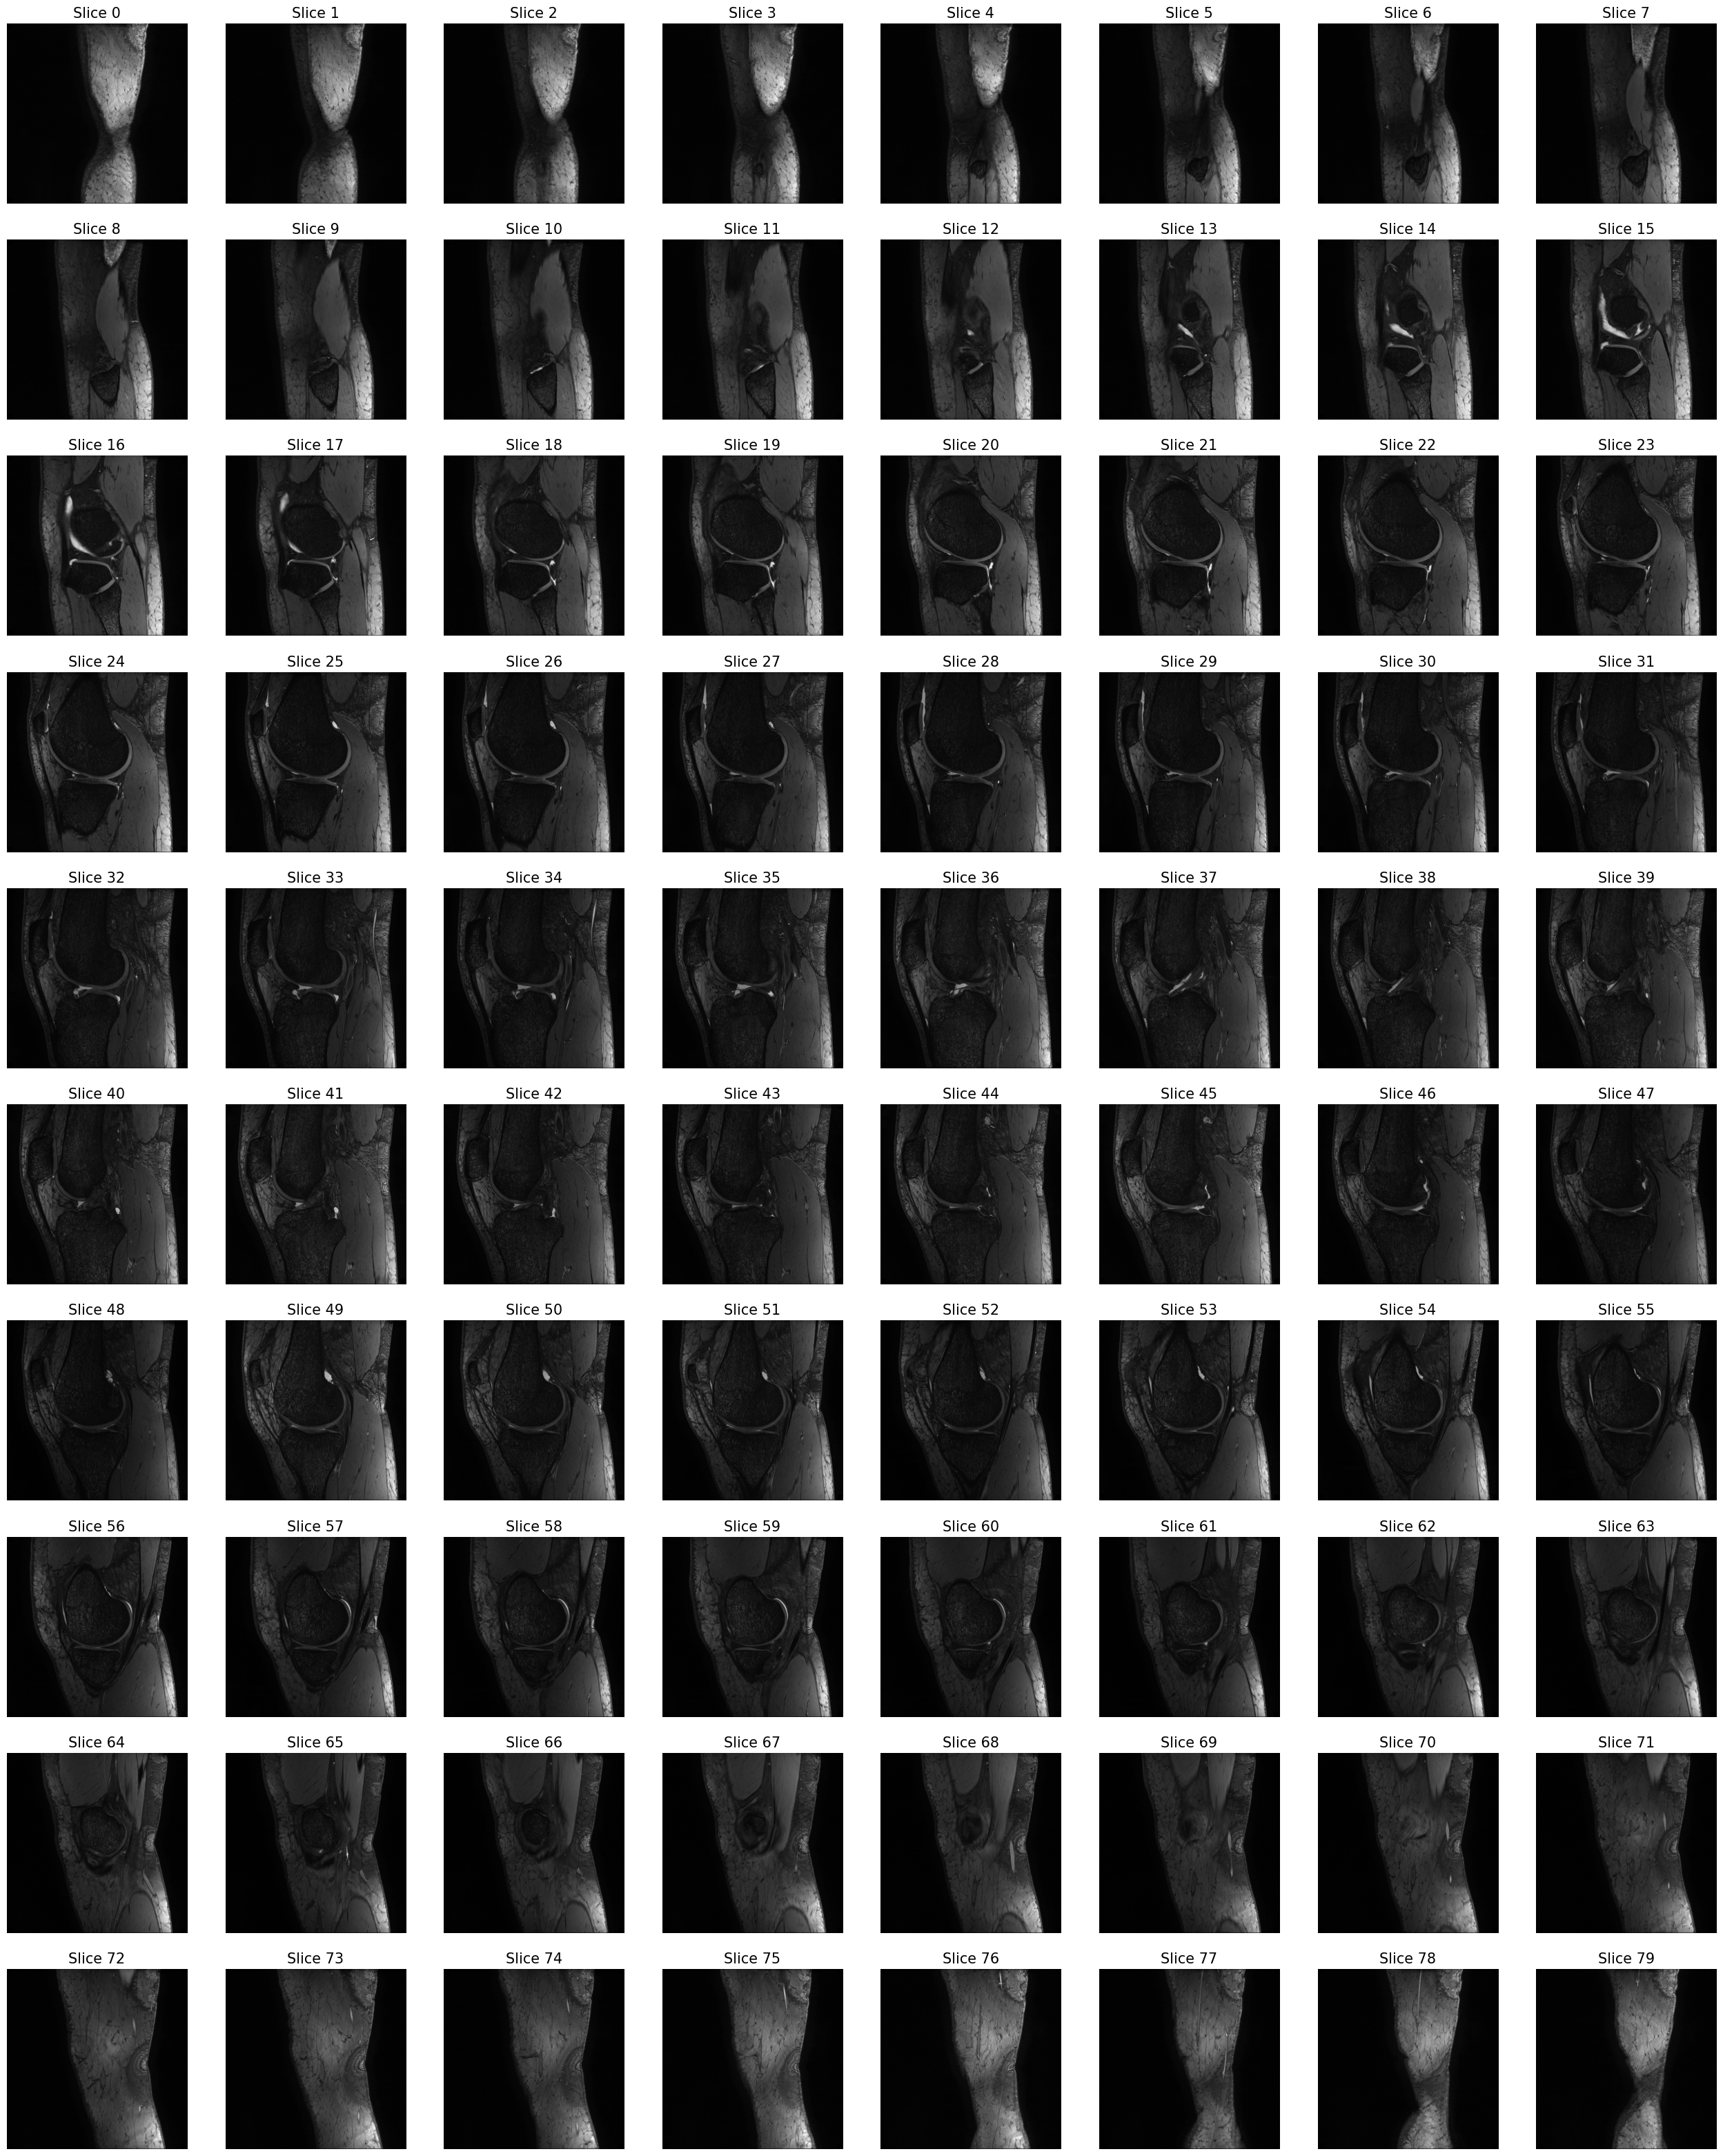

In [4]:
nrows = 10
ncols = 8
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
# axes = axes.flatten()

for i in range(80):    
    image = normalizedImages[i]
    axes[i // ncols, i % ncols].imshow(image, cmap='gray')
    axes[i // ncols, i % ncols].axis("off")
    axes[i // ncols, i % ncols].set_title('Slice '+str(i), fontsize=15)

### Example: visualising No01-footballer's segmentation mask slices (80)

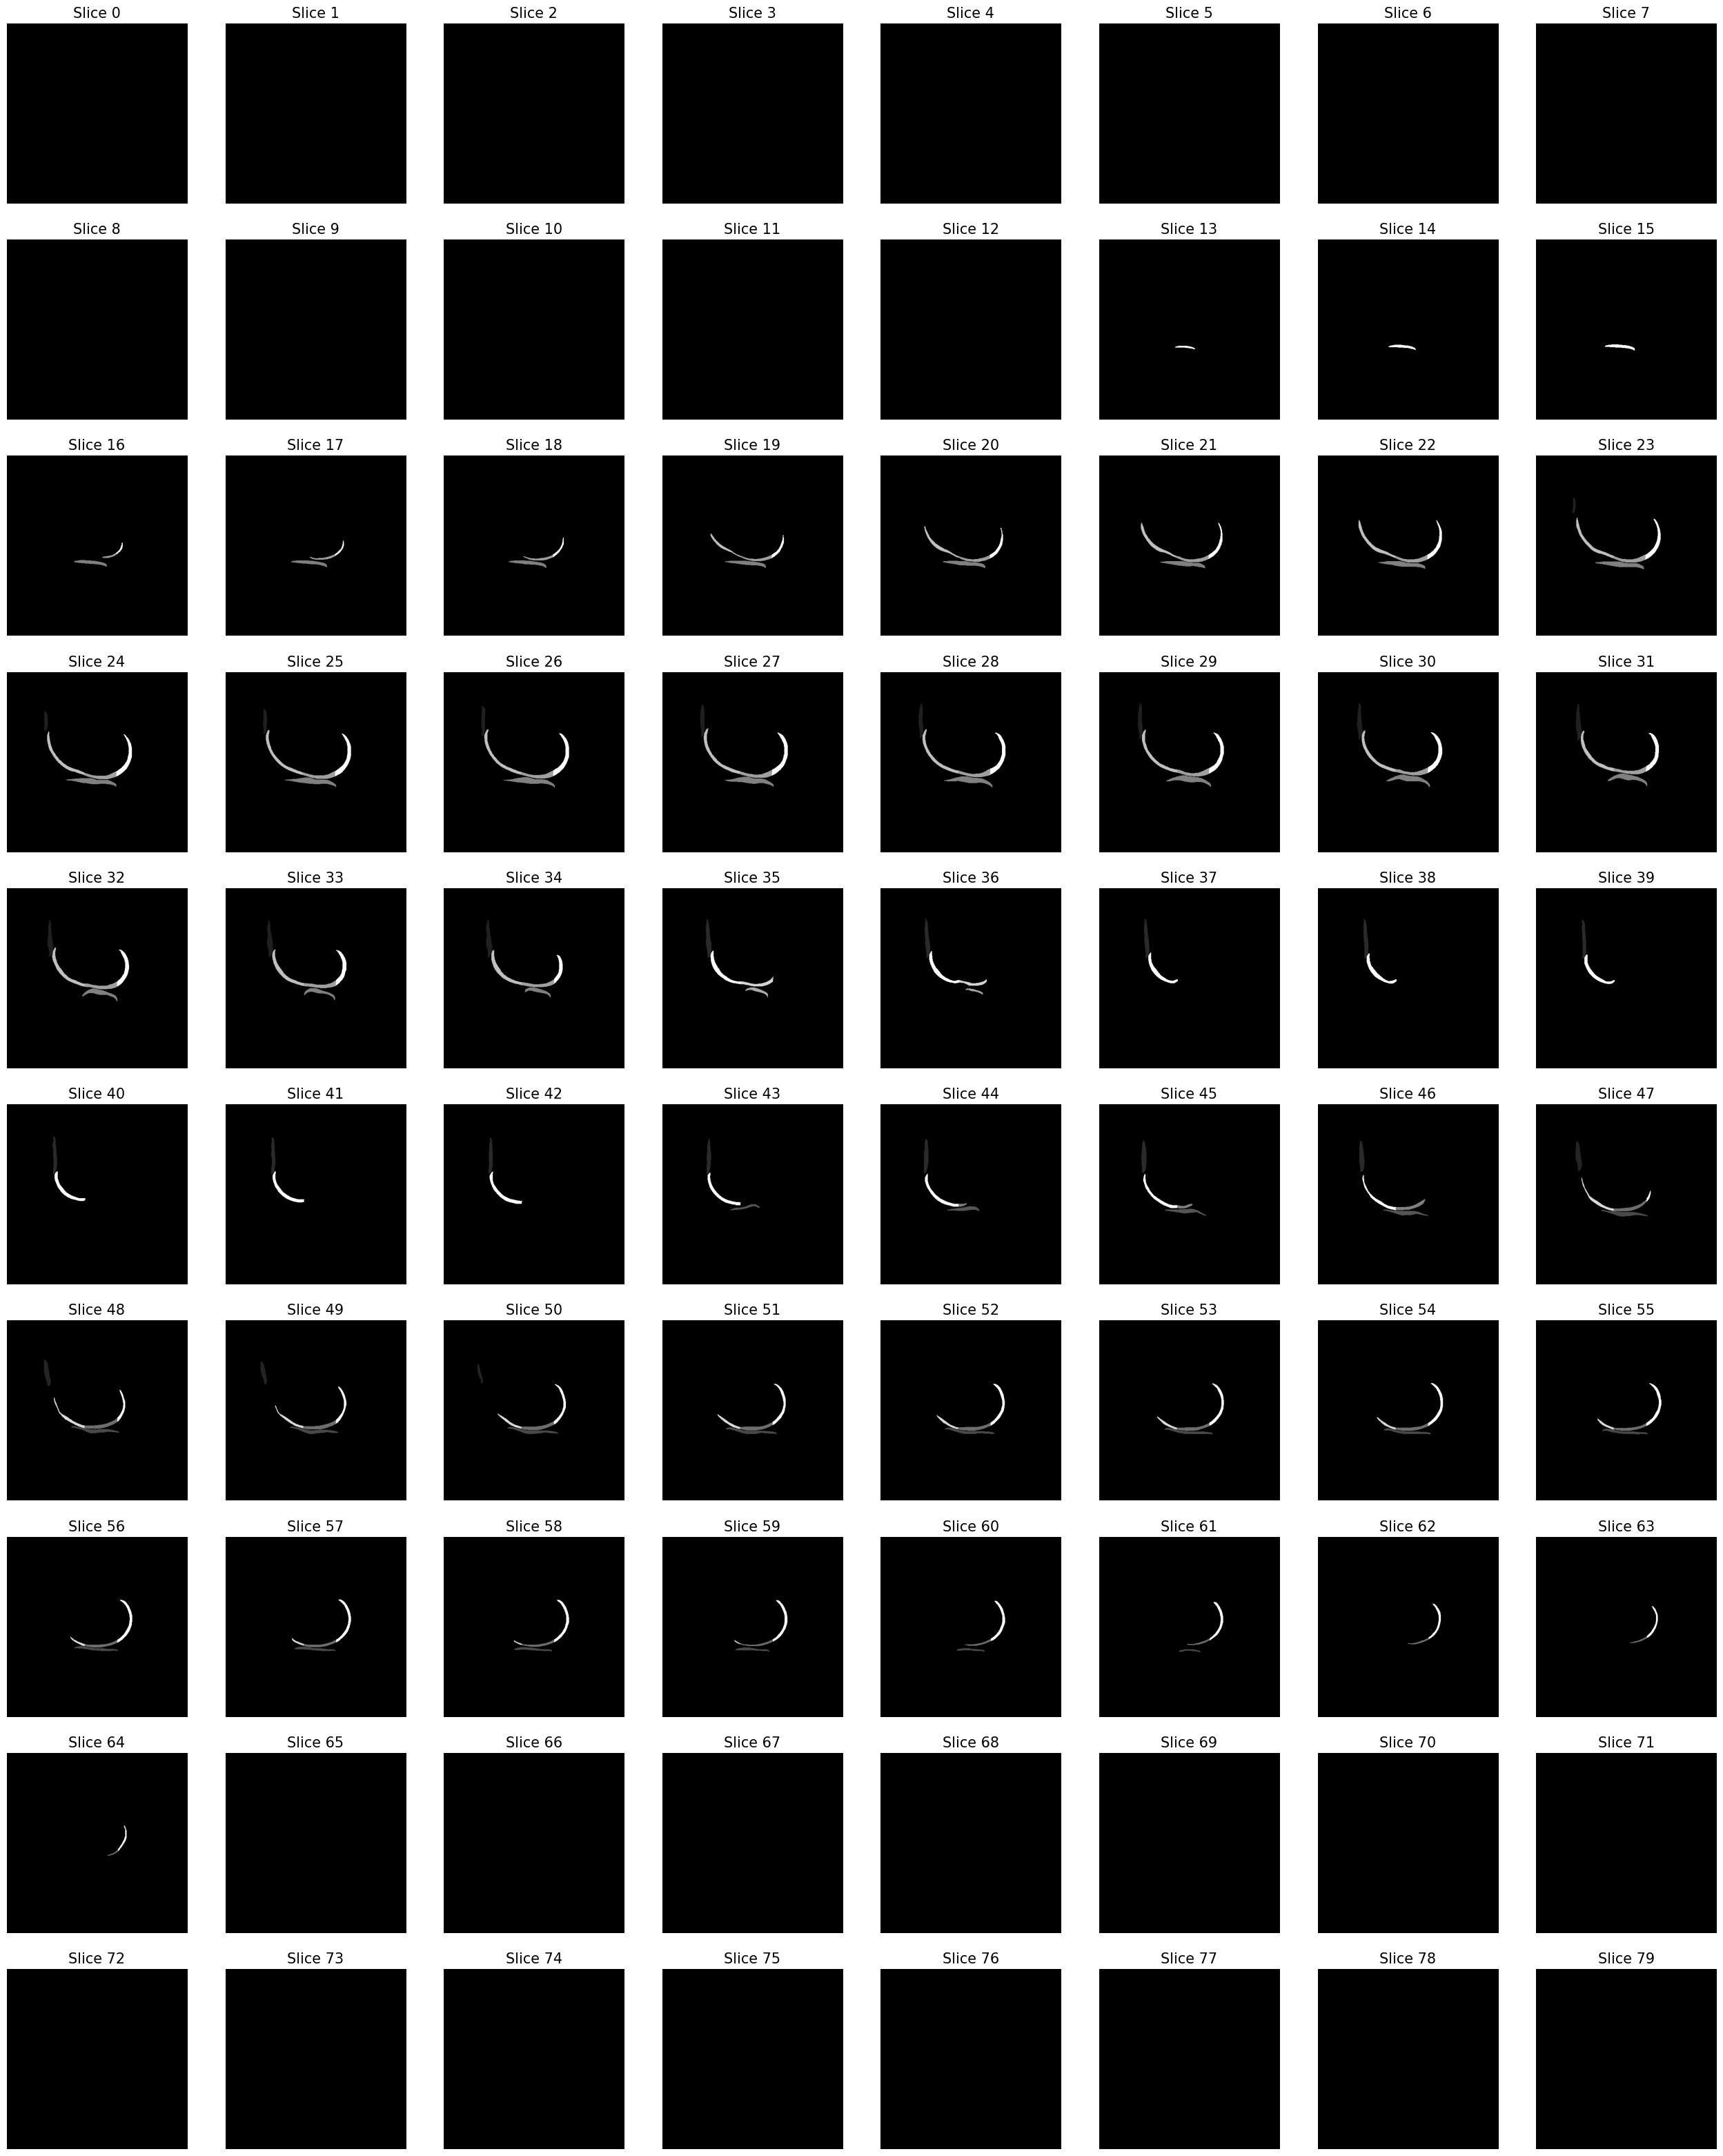

In [5]:
nrows = 10
ncols = 8
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
# axes = axes.flatten()

for i in range(80):    
    label = exportedSegMasks[i]
    axes[i // ncols, i % ncols].imshow(label, cmap='gray')
    axes[i // ncols, i % ncols].axis("off")
    axes[i // ncols, i % ncols].set_title('Slice '+str(i), fontsize=15)

## 3. Save individual images and labels

In [6]:
img_path = '7TMRIs/IMAGES'
label_path = '7TMRIs/LABELS'

slices_num = [elem.astype(int).tolist() for elem in slices]
slices_num = [elem[0] for elem in slices_num]

# Change the filenames as you wish
names = ['Ffootballer1_R', 'Ffootballer1_L', 
        'Ffootballer2_R', 'Ffootballer2_L', 
        'footballer1_R', 
        'footballer2_R', 
        'footballer3_R', 'footballer3_L', 
        'footballer4_R', 'footballer4_L', 
        'subject1_L', 'subject1_R', 
        'subject2_L', 'subject2_R']

for i in range(len(normalizedImages)): # 1120
    current_file = filenames_str[i]
    new_name_p = names[uniqueFiles.index(current_file)]
    new_name = new_name_p + '_'+str(slices_num[i]).zfill(3)
    
### Uncomment to create image and label files
#     new_img = h5py.File(os.path.join(img_path, new_name+'.im'), 'w')
#     new_img.create_dataset("data", data=normalizedImages[i])
#     new_img.close()
    
#     new_label = h5py.File(os.path.join(label_path, new_name+'.seg'), 'w')
#     new_label.create_dataset("data", data=exportedSegMasks[i])
#     new_label.close()
    
#     print(new_name)

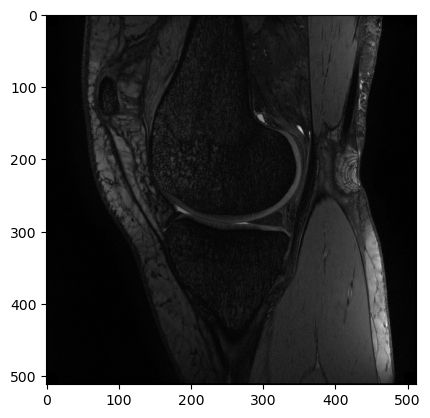

In [7]:
### Example: plotting one MRI slice 

with h5py.File(os.path.join(img_path, 'Ffootballer1_L_050.im')) as hf:
    img = np.array(hf['data'])
    hf.close()

plt.imshow(img, cmap='gray')

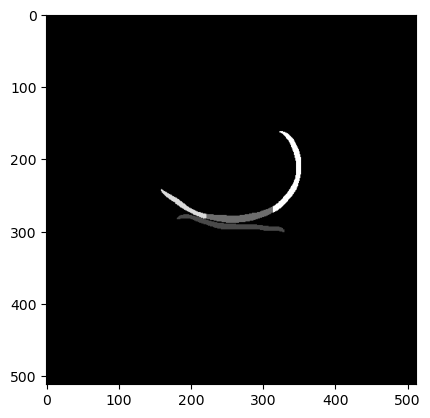

In [8]:
### Example: plotting one MRI slice label (multi-class)

with h5py.File(os.path.join(label_path, 'Ffootballer1_L_050.seg')) as hf:
    label = np.array(hf['data'])
    hf.close()

plt.imshow(label, cmap='gray')

## 4. Convert multi-class label to single-class

In [9]:
print(Label)
print(LabelNames)

[1 2 3 4 5 6 7 8 9]
[b'Patella' b'Medial Tibia' b'Central medial femoral condyle'
 b'Lateral Tibia' b'Central lateral femoral condyle'
 b'Trochlea of the femur' b'Posterior medial femoral condyle'
 b'Posterior lateral femoral condyle' b'Patella Bone']


7


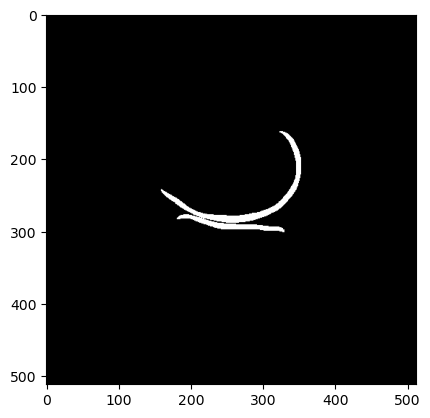

In [10]:
label_path = '7TMRIs/LABELS'

with h5py.File(os.path.join(label_path, 'Ffootballer1_L_050.seg')) as hf:
    label = np.array(hf['data'])
    hf.close()

print(np.max(label)) # maximum label number 
bin_label = np.where(label != 0, 1, 0) # Converting to single-class: setting all non-zero values in the label to 1 and all zero values to 0
plt.imshow(bin_label, cmap='gray')

In [12]:
label_path = '7TMRIs/LABELS'
new_label_path = '7TMRIs/LABELS_SINGLE'

# Convert all labels and save new files 
for i in range(len(os.listdir(label_path))):
    filename = os.listdir(label_path)[i]
    with h5py.File(os.path.join(label_path, filename)) as hf:
        label = np.array(hf['data'])
        hf.close()

    bin_label = np.where(label != 0, 1, 0) # convert all non-zero pixels to 1

### Uncomment to save new binary label in new filepath
#     new_bin_label = h5py.File(os.path.join(new_label_path, filename), 'w')
#     new_bin_label.create_dataset("data", data=bin_label)
#     new_bin_label.close()
    
#     if i % 50 == 0:
#         print(i, ' done')

## 5. Slice extraction 
#### Extract all the slices with max labels (same as 3TMRIs)

In [1]:
# idx_max = 60, view_max = 2
def slice_extract(label_filepath, image_filepath):
    fileList = os.listdir(label_filepath)
    
    names = ['Ffootballer1_R', 'Ffootballer1_L', 
        'Ffootballer2_R', 'Ffootballer2_L', 
        'footballer1_R', 
        'footballer2_R', 
        'footballer3_R', 'footballer3_L', 
        'footballer4_R', 'footballer4_L', 
        'subject1_L', 'subject1_R', 
        'subject2_L', 'subject2_R']
    
    extractedList = []
    
    for prefix in names:
        subj_labels = [f for f in fileList if f.startswith(prefix)]
        print(len(subj_labels)) # should be 80
        
        max_ones = 0
        max_ones_idx = 0
        for label in subj_labels:
            
            with h5py.File(os.path.join(label_filepath, label)) as hf:
                lbarray = np.array(hf['data'])
                hf.close()
        
            num_ones = np.count_nonzero(lbarray) # count number of nonzeros in the label
            if num_ones >= max_ones:
                max_ones = num_ones # replace max number of ones

                name, extension = os.path.splitext(label)
                max_slice_idx = int(name[-3:]) # save the slice index
    
        print('Max slice: ', max_slice_idx, ' with ', max_ones)
        print('filename: ', prefix+'_'+str(max_slice_idx).zfill(3))
        print()
        # extract the 4 slices before and 6 slices after this max slice => total 10 slices
        for i in range(max_slice_idx-4, max_slice_idx+6):
            onlyname = prefix+'_'+str(i).zfill(3)

            imgInfo = {
                "image": os.path.join(image_filepath, onlyname+'.im'), 
                "label": os.path.join(label_filepath, onlyname+'.seg')
              }

            extractedList.append(imgInfo)
    
    return extractedList

In [ ]:
img_path = '7TMRIs/IMAGES'
label_path = '7TMRIs/LABELS_SINGLE'
all_extracted = slice_extract(label_path, img_path)
print(len(train_extracted))

In [ ]:
with open("7TMRIs/all_extracted.pkl", "wb") as f:
    pickle.dump(all_extracted, f)

## 6. Make `json` file
#### train: test = 90:10 
Train data is further divided into train and val data for cross-validation (80:20)

In [ ]:
with open('7TMRIs/all_extracted.pkl', 'rb') as f:
    all_extracted = pickle.load(f)
    
len(all_extracted)

In [ ]:
nrows = 5
ncols = 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
# axes = axes.flatten()

for i in range(50):
    with h5py.File(all_extracted[i]['image']) as hf:
        label = np.array(hf['data'])
        hf.close()
    axes[i // ncols, i % ncols].imshow(label, cmap='gray')
    axes[i // ncols, i % ncols].axis("off")
    axes[i // ncols, i % ncols].set_title('Slice '+str(i), fontsize=15)

In [ ]:
def train_valid_test(data_list, portion):
    
    datasetDict = {}
    datasetDict["name"] = "7T MRI for downstream segmentation"
    datasetDict['date'] = '19/04/2023'
    datasetDict["description"] = "Contains extracted 7TMRI 2D slices for cartilage segmentation (half dataset)"
    datasetDict["labels"] = {
        "0": "background", 
        "1": "cartilage"
    }      
    
    # train-valid-test split on all_data
    train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=42)
    
    # portion of dataset used
    train_data = random.sample(train_data, math.floor(len(train_data)*portion))
#     train_data = all_data[:math.floor(len(train_data)*portion)]
    
    datasetDict["numTrain"] = len(train_data)
    datasetDict["numTest"] = len(test_data)
    
    datasetDict["train"] = train_data
    datasetDict["test"] = test_data
    
    return datasetDict 

In [ ]:
jsonDict = train_valid_test(all_extracted, 0.5)

nolabel_out_file = open('7TMRIs/7TMRI_dataset_2.json', "w")
json.dump(jsonDict, nolabel_out_file, indent = 8)
nolabel_out_file.close()